In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

sns.set(style="whitegrid")
np.random.seed(42)

In [9]:
# Generate synthetic e-commerce data
n_customers = 5000

data = pd.DataFrame({
    "customer_id": np.arange(n_customers),
    "age": np.random.randint(18, 65, size=n_customers),
    "gender": np.random.choice(["Male", "Female"], size=n_customers),
    "annual_income": np.random.randint(20000, 120000, size=n_customers),
    "previous_purchases": np.random.randint(0, 20, size=n_customers),
    "avg_cart_value": np.round(np.random.uniform(20, 500, size=n_customers), 2),
    "days_since_last_purchase": np.random.randint(0, 365, size=n_customers),
})

# Simulate target variable (purchase this month)
data["purchase"] = (
    (0.3 * (data["previous_purchases"] > 5)) +
    (0.2 * (data["annual_income"] > 50000)) +
    (0.25 * (data["days_since_last_purchase"] < 90)) +
    (0.25 * (data["avg_cart_value"] > 100))
)
data["purchase"] = np.where(data["purchase"] + np.random.normal(0, 0.2, n_customers) > 0.5, 1, 0)

data.head()


,customer_id,age,gender,annual_income,previous_purchases,avg_cart_value,days_since_last_purchase,purchase
0,0,56,Male,77676,9,149.83,164,1
1,1,46,Female,31560,2,42.39,63,0
2,2,32,Male,74401,2,227.53,47,1
3,3,60,Male,70468,19,417.17,149,1
4,4,25,Male,52463,15,31.84,157,0


C:\Users\tejas\AppData\Local\Temp\ipykernel_33084\2194872987.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="purchase", palette="viridis")


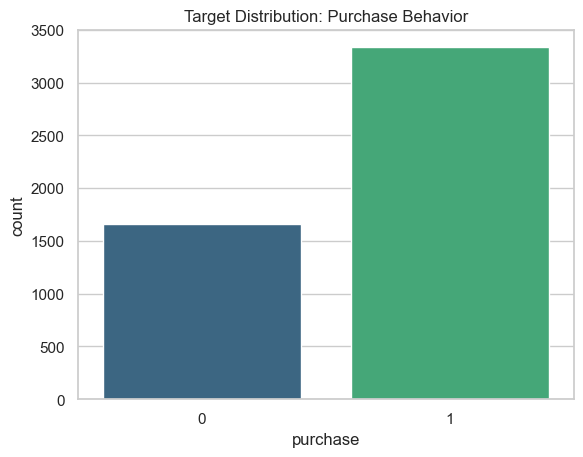

C:\Users\tejas\AppData\Local\Temp\ipykernel_33084\2194872987.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="purchase", y="annual_income", palette="coolwarm")


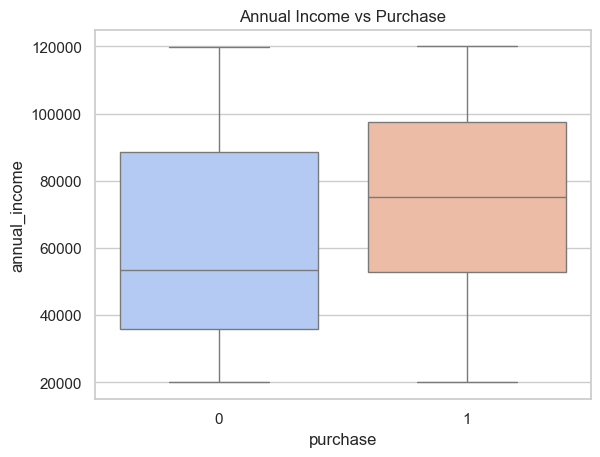

In [10]:
# Purchase distribution
sns.countplot(data=data, x="purchase", palette="viridis")
plt.title("Target Distribution: Purchase Behavior")
plt.show()

# Income vs purchases
sns.boxplot(data=data, x="purchase", y="annual_income", palette="coolwarm")
plt.title("Annual Income vs Purchase")
plt.show()


In [11]:
# Feature engineering
data["high_income"] = (data["annual_income"] > 60000).astype(int)
data["loyal_customer"] = (data["previous_purchases"] > 10).astype(int)
data["recent_engagement"] = (data["days_since_last_purchase"] < 30).astype(int)

# One-hot encoding for gender
data = pd.get_dummies(data, columns=["gender"], drop_first=True)

data.head()


,customer_id,age,annual_income,previous_purchases,avg_cart_value,days_since_last_purchase,purchase,high_income,loyal_customer,recent_engagement,gender_Male
0,0,56,77676,9,149.83,164,1,1,0,0,True
1,1,46,31560,2,42.39,63,0,0,0,0,False
2,2,32,74401,2,227.53,47,1,1,0,0,True
3,3,60,70468,19,417.17,149,1,1,1,0,True
4,4,25,52463,15,31.84,157,0,0,1,0,True


In [12]:
X = data.drop(columns=["customer_id", "purchase"])
y = data["purchase"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [13]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


c:\users\tejas\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64       481
           1       0.82      0.86      0.84      1019

    accuracy                           0.78      1500
   macro avg       0.75      0.73      0.74      1500
weighted avg       0.77      0.78      0.77      1500



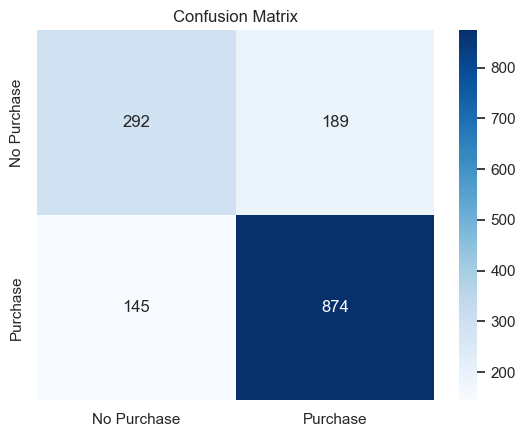

In [14]:
y_pred = model.predict(X_test)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Purchase", "Purchase"], 
            yticklabels=["No Purchase", "Purchase"])
plt.title("Confusion Matrix")
plt.show()


C:\Users\tejas\AppData\Local\Temp\ipykernel_33084\2981711949.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance.head(10), x="importance", y="feature", palette="mako")


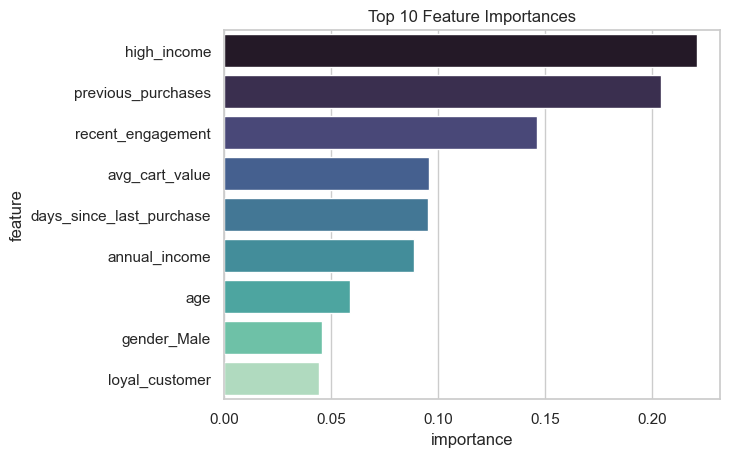

In [15]:
importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

sns.barplot(data=importance.head(10), x="importance", y="feature", palette="mako")
plt.title("Top 10 Feature Importances")
plt.show()
